In [1]:
%load_ext autoreload
# for leonhard
import os
try:
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
except KeyError:
    pass

import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import stein
import mnist
import models
import metrics
import distributions
import config as cfg
import utils
from jax import jit, grad, value_and_grad
import plot

key = random.PRNGKey(0)

Loading data...


In [4]:
target = distributions.Funnel(2)
reference = distributions.Gaussian([0, 0], [1, 1])

init_particles = reference.sample(200)
target_samples = target.sample(200)
logp, dlogp = vmap(value_and_grad(target.logpdf))(init_particles)

key, subkey = random.split(key)
stein_network = models.SDLearner(target_dim=2,
                                 key=subkey,
                                 sizes=[32, 32, 2],
                                 learning_rate=2e-3,
                                 patience=3,
                                 dropout=True,
                                 normalize_inputs=False,
                                 aux=False)


def true_f(x):
    return grad(lambda x: target.logpdf(x) - reference.logpdf(x))(x)


@jit
def diff(params):
    f = utils.negative(stein_network.get_field(params=params))
    return vmap(lambda x: f(x) - grad(target.logpdf)(x))(init_particles).mean()


# approx best achievalbe (cause this term should be zero)
diff_best = vmap(grad(reference.logpdf))(init_particles).mean()

@jit
def squared_error(params):
    """squared error, rescaled to match loss"""
    f = utils.negative(stein_network.get_field(params=params))
    sqe = lambda x: (f(x)**2 / 2 - f(x) * true_f(x)).sum()
    return vmap(sqe)(init_particles).mean()

In [5]:
# optimal loss
# a) true
l2 = utils.l2_norm_squared(init_particles, true_f) # = sd(f*) / (2 LAMBDA_REG)
true_sd = l2
min_loss = - l2 / 2

# b) hutchinson
key, subkey = random.split(key)
random_estimate_sd = stein.stein_discrepancy_hutchinson(
    subkey, init_particles, target.logpdf, true_f)

print("analytical sd:", true_sd)
print("hutchinson estimate:", random_estimate_sd)
print("ratio:", true_sd / random_estimate_sd)

rundata = {}

analytical sd: 7.049994
hutchinson estimate: 7.0368514
ratio: 1.0018677


In [28]:
for _ in tqdm(range(500)):
    stein_network.step(*init_particles.split(2), *dlogp.split(2))
    metrics.append_to_log(rundata,
                        {
                            "diff": diff(stein_network.params),
                            "squared_error": squared_error(stein_network.params),
                        })

100%|██████████| 500/500 [00:07<00:00, 69.99it/s]


In [29]:
stein_network.rundata.keys()

dict_keys(['train_steps', 'global_gradient_norm', 'l2', 'loss', 'sd', 'val_l2', 'val_loss', 'val_sd'])

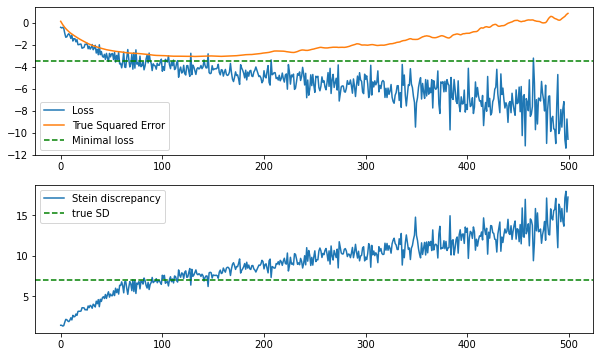

In [30]:
%matplotlib inline
fig, axs = plt.subplots(2, figsize=[10, 6])
axs = axs.flatten()

ax = axs[0]
ax.plot(stein_network.rundata['loss'], label="Loss")
# ax.plot(stein_network.rundata['validation_loss'])
ax.plot(rundata['squared_error'], label='True Squared Error')
ax.axhline(y=min_loss, linestyle="--", color="green", label="Minimal loss")
ax.legend()

ax = axs[1]
ax.plot(stein_network.rundata['sd'], label="Stein discrepancy")
# ax.plot(stein_network.rundata['validation_sd'])
ax.axhline(y=true_sd, linestyle="--", color="green", label="true SD")
ax.legend()

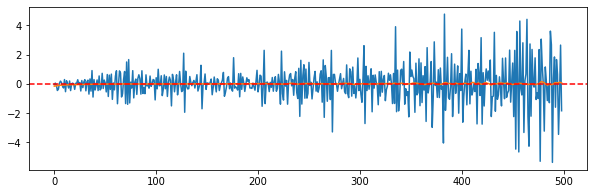

In [31]:
fig, axs = plt.subplots(figsize=[10, 3])
plt.plot(onp.diff(stein_network.rundata['loss']))
# plt.plot(onp.diff(stein_network.rundata['validation_loss']))
plt.plot(onp.diff(rundata['squared_error']))
plt.axhline(y=0, linestyle="--", color="red")

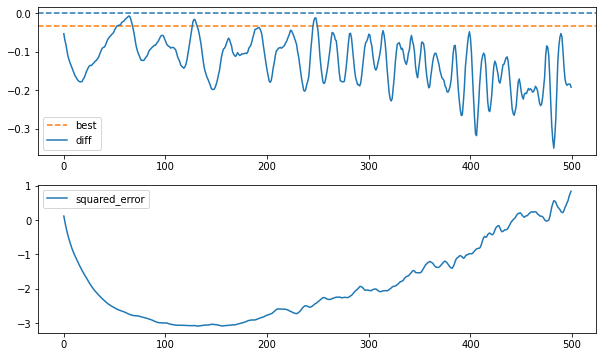

In [32]:
fig, axs = plt.subplots(2, figsize=[10, 6])

axs[0].axhline(y=0, linestyle="--")
axs[0].axhline(y=diff_best, linestyle="--", label="best", color="tab:orange")

for ax, (k, v) in zip(axs.flatten(), rundata.items()):
    ax.plot(v, label=k)
    ax.legend()
    
    
# difference blue - orange is sum of (f_q MC error) and (f_p approx error)

In [33]:
stein_network.rundata.keys()

dict_keys(['train_steps', 'global_gradient_norm', 'l2', 'loss', 'sd', 'val_l2', 'val_loss', 'val_sd'])

# entire trajectory

In [6]:
metrics_tracer = metrics.get_funnel_tracer(target_samples)
particles = models.Particles(subkey,
                             gradient=stein_network.gradient,
                             init_samples=init_particles,
                             learning_rate=1e-2,
                             compute_metrics=metrics_tracer)

g = jit(vmap(grad(target.logpdf)))

In [7]:
for _ in tqdm(range(1000)):
    train_batch = next(mnist.train_batches)
    key, subkey = random.split(key)
    split_particles = particles.next_batch(subkey)
    split_dlogp = [g(x) for x in split_particles]

    stein_network.train(split_particles, split_dlogp, n_steps=30)
    particles.step(stein_network.params)

100%|██████████| 1000/1000 [00:19<00:00, 50.85it/s]


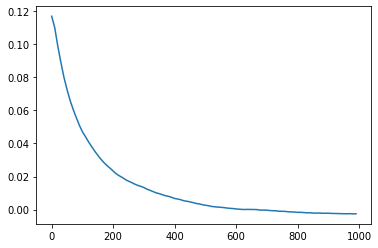

In [8]:
plt.plot(*zip(*particles.rundata['rbf_mmd']))

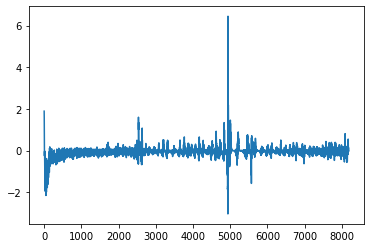

In [9]:
plt.plot(stein_network.rundata['loss'])

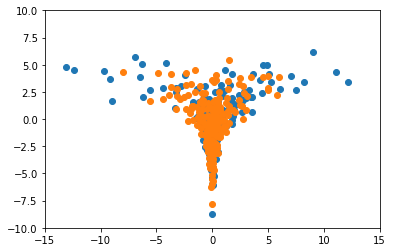

In [14]:
%matplotlib inline
fig, ax = plt.subplots()
ax.set(xlim=[-15, 15], ylim=[-10, 10])
plot.scatter(target_samples, label="true")
plot.scatter(particles.particles)

In [11]:
trajectory = onp.array(particles.rundata['particles'])

In [13]:
%matplotlib widget
fig, ax = plt.subplots()
lim = (-15, 15)
ax.set(xlim=lim, ylim=lim)
plot.scatter(target_samples, label="true")
plt.legend()
plot.animate_array(trajectory, interval=1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …